# Airbnb data analysis
**For review purposes:** http://nbviewer.jupyter.org/github/SilvrDuck/CS-401/blob/master/project/Project.ipynb

## Introduction

The massive adoption of the Airbnb service in the world has changed the way people travel, and how the hotel industry works. There is a lot of controversy about this service. The City of Berlin chose to ban the service entirely, and later made exception allowing people having only a secondary residency there to rent it, but for a limited amount of time per year. In the case of Amsterdam, a deal has been made directly with the company to limit the number of days that any given apartment can be rented.

But what are the concerns here? Is it the hotel industry that suffers? Are the denizens of those cities directly threatened by rises in housing prices and speculation? In this work, we want to explore the data offered by the website http://insideairbnb.com/. We will try not to take any conclusion beforehand and simply try to find correlation between the usage of the housing service and different indicators published by the national statistics service themselves.

We chose to do those analysis on the two aforementioned cities, Berlin and Amsterdam, since they are both major touristic capitals in Europe, and quite close to each other. Comparing the two might help us have more insight on the effect of the business. The two cities have put in place major regulation on the service in 2016. We will therefore compare analyse the evolution of those factor between 2015 and 2017.

## Inside Airbnb data imports and helper functions definitions

Here we load and prepare the date for analysis of the Inside Airbnb corpus.

In [1]:
%matplotlib inline

import os
import folium
import numpy  as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

DATASETS_ROOT="datasets"
INSIDE="Inside-Airbnb"
NATIONAL="National"
CITIES=["Amsterdam", "Berlin"]

In [2]:
def load_amsterdam_geo():
    amsterdam_topo = os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson")
    m = folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
    )

    folium.GeoJson(
        amsterdam_topo,
        name='geojson'
    ).add_to(m)
    
    return m

In [3]:
def load_berlin_geo():
    berlin_topo = os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson")
    m = folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    )

    folium.GeoJson(
        open(berlin_topo,  'r', encoding='utf-8').read(),
        name='geojson'
    ).add_to(m)
    
    return m

In [4]:
def load_listing(city, year, full = False):
    filename = "listings.csv" if not full else "listings 2.csv"
    file = os.path.join(DATASETS_ROOT, city, INSIDE, year, filename)
    return pd.read_csv(file)

In [5]:
def load_calendar_data(city, year):
    file = os.path.join(DATASETS_ROOT, city, INSIDE, year, "calendar.csv")
    return pd.read_csv(file)

def load_listing_data(city, year):
    pass

The following method creates a choropleth for a city given the starting map, a path to the GeoJSON file as well as a dataframe containing at least two columns:

- counts: the number of AirBnB
- neigbourhood: The name of the neigbourhood

In [6]:
def neighbourhood_map(start_map, path, stats):
    from shapely.geometry import Polygon, mapping
    
    geo_df = gpd.read_file(path)

    text = []
    list_geo = []
    gj = []

    for i in range(stats.index.size):
        current = stats.loc[i]
        selected = geo_df[geo_df['neighbourhood'] == current.neighbourhood]

        mp = mapping(selected.geometry)
        list_geo.append(selected)
        text.append(current.neighbourhood +  '<br>' + 'Number of available AirBnB: ' + str(current.counts))
        gj.append(folium.GeoJson(mp, style_function=lambda feature: {
            'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))
    
    xs = sorted(stats.counts.tolist())
    L = len(xs)
    s = int(L/5)
    sublist = [xs[p:p+s] for p in range(0, L, s)]
   
    sublist = [sub[len(sub)-1]+1 for sub in sublist]

    start_map.choropleth(
        geo_data=open(path,  'r', encoding='utf-8').read(),
        name='choropleth',
        data=stats,
        columns=['neighbourhood', "counts"],
        fill_color='PuBuGn',
        fill_opacity=0.5,
        line_opacity=0.2,
        key_on='properties.neighbourhood',
        legend_name='Number of AirBnB available',
        threshold_scale=sublist
    )

    for i in range(geo_df.index.size):
        if i < len(text):
            gj[i].add_child(folium.Popup(text[i]))
            gj[i].add_to(start_map)
    return start_map

In [7]:
def clean_calendar(dataframe):
    # Listing ID is the rental ID, we need it as a string, not a number
    dataframe["listing_id"] = dataframe["listing_id"].apply(lambda x: str(x))

    # We remove the $ from the price and the , as well
    dataframe["price"] = dataframe["price"].apply(lambda p: p if isinstance(p, float) else float(p.replace('$', '').replace(',', '')))
    return dataframe

In [8]:
amsterdam_calendar_data_2015 = load_calendar_data("Amsterdam", "2015")
amsterdam_calendar_data_2017 = load_calendar_data("Amsterdam", "2017")
# We have the same data and layout in the two dataframes (2015 and 2017) but the date contains the year.
# to match the data together, we first have to remove the year from the "date" column.
# The first step is to add a new column of the date without the year in both dataframe
amsterdam_calendar_data_2015['date_wo_year'] = amsterdam_calendar_data_2015["date"].apply(lambda x: str(x[5:]))
amsterdam_calendar_data_2017['date_wo_year'] = amsterdam_calendar_data_2017["date"].apply(lambda x: str(x[5:]))

amsterdam_listing_2015 = load_listing("Amsterdam", "2015")
amsterdam_listing_2017 = load_listing("Amsterdam", "2017")

amsterdam_listing_2015_full = load_listing("Amsterdam", "2015", True)
amsterdam_listing_2017_full = load_listing("Amsterdam", "2017", True)


amsterdam_calendar_data_2015 = clean_calendar(amsterdam_calendar_data_2015)
amsterdam_calendar_data_2017 = clean_calendar(amsterdam_calendar_data_2017)

In [9]:
amsterdam_map = load_amsterdam_geo()

In [10]:
berlin_calendar_data_2016 = load_calendar_data("Berlin", "2016")
berlin_calendar_data_2017 = load_calendar_data("Berlin", "2017")

berlin_listing_2016 = load_listing("Berlin", "2016")
berlin_listing_2017 = load_listing("Berlin", "2017")

berlin_listing_2016_full = load_listing("Berlin", "2016", True)
berlin_listing_2017_full = load_listing("Berlin", "2017", True)

berlin_calendar_data_2016 = clean_calendar(berlin_calendar_data_2016)
berlin_calendar_data_2017 = clean_calendar(berlin_calendar_data_2017)

In [11]:
berlin_map = load_berlin_geo()

## Exploring data from the Inside Airbnb dataset

### Berlin - Inside Airbnb

Here we display the density of usage of Airbnb across the different neighbourhood of the city.
The first step is to match neighbourhood from the GeoJSON and the listing.

Let's extract the neighbourhoods from the listing:

In [12]:
berlin_listing_ng_names = berlin_listing_2016.neighbourhood.unique()
berlin_listing_2016_neig_stats = berlin_listing_2016.groupby("neighbourhood").size().reset_index(name="counts")

We want to be able to see the number of AirBnB inside each neighbourhood, so we load the GeoJSON as a GeoPanda and then map it with the dataframe created above

In [13]:
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), berlin_listing_2016_neig_stats)
# Please note that the following map has had issue displaying in chrome. It works fine with firefox 58 though.

From this map, we can conclude that the neighboorhoods in the center are more attractive on AirBnB than the one farthest from the center. It's probably because tourists prefers to be in the center of the town more than being far from the touristic places.

We explore a bit of temporal data to see how the service is used during one full year. We look at what has changer between 2016 and 2017. This graph shows the amount of Airbnb available per neighbourhood per year.

This graph shows the neighbourhoods with the highest popularity increase between 2016and 2017.

In [14]:
berlin_listing_2017_neig_stats = berlin_listing_2017.groupby("neighbourhood").size().reset_index(name="counts")
berlin_ng_stat_merge = berlin_listing_2016_neig_stats.merge(berlin_listing_2017_neig_stats, on='neighbourhood')
berlin_ng_stat_merge['diff'] = berlin_ng_stat_merge['counts_y'] - berlin_ng_stat_merge['counts_x']
berlin_ng_stat_merge['increase'] = berlin_ng_stat_merge['counts_y'] / berlin_ng_stat_merge['counts_x'] 
berlin_ng_stat_merge['2016'] = berlin_ng_stat_merge['counts_x']
berlin_ng_stat_merge['2017'] = berlin_ng_stat_merge['counts_y']


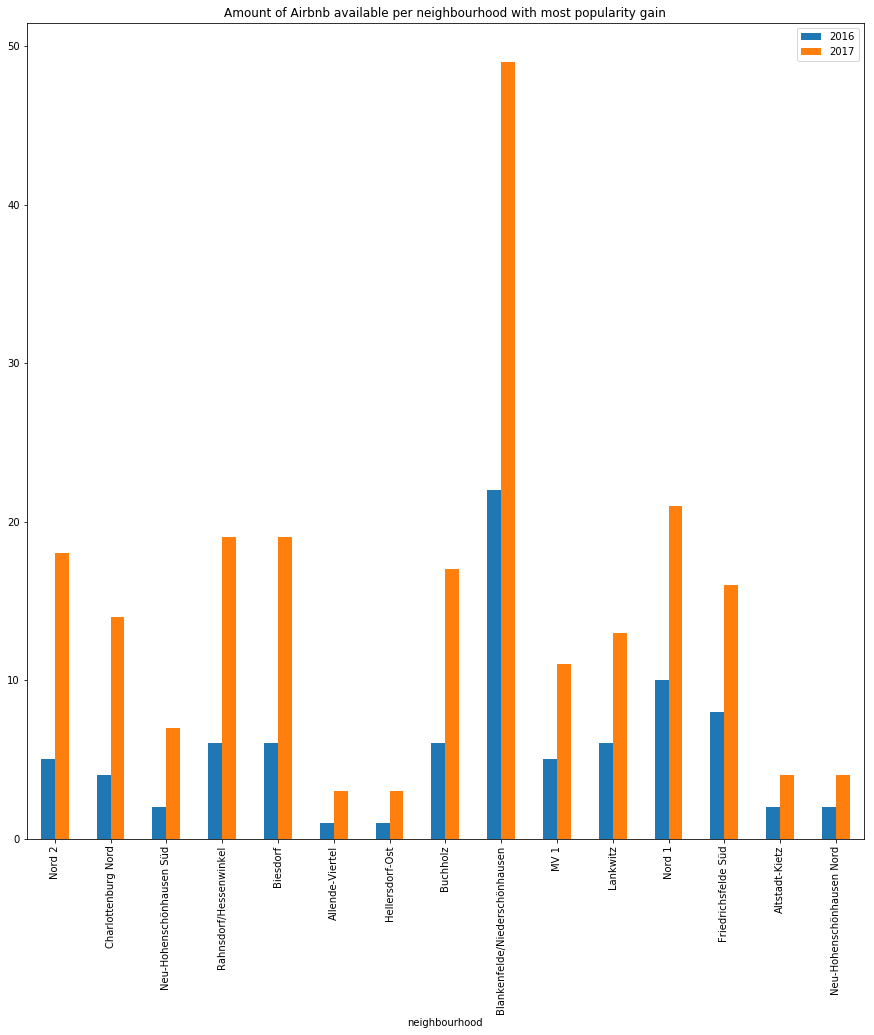

In [15]:
berlin_ng_stat_merge = berlin_ng_stat_merge.sort_values(by=['increase'], ascending=False)
berlin_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['2016', '2017'], kind='bar', figsize=(15, 15), title="Amount of Airbnb available per neighbourhood with most popularity gain")

In [16]:
tmp = berlin_ng_stat_merge
tmp = tmp.iloc[:15, :].reset_index()
tmp['counts'] = tmp['increase']
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), tmp)

As we can see, some neighbourhood are much more popular in 2017 than there were in 2015, but what is interesting is that we can also see that many neighbourhoods have also lost in popularity:

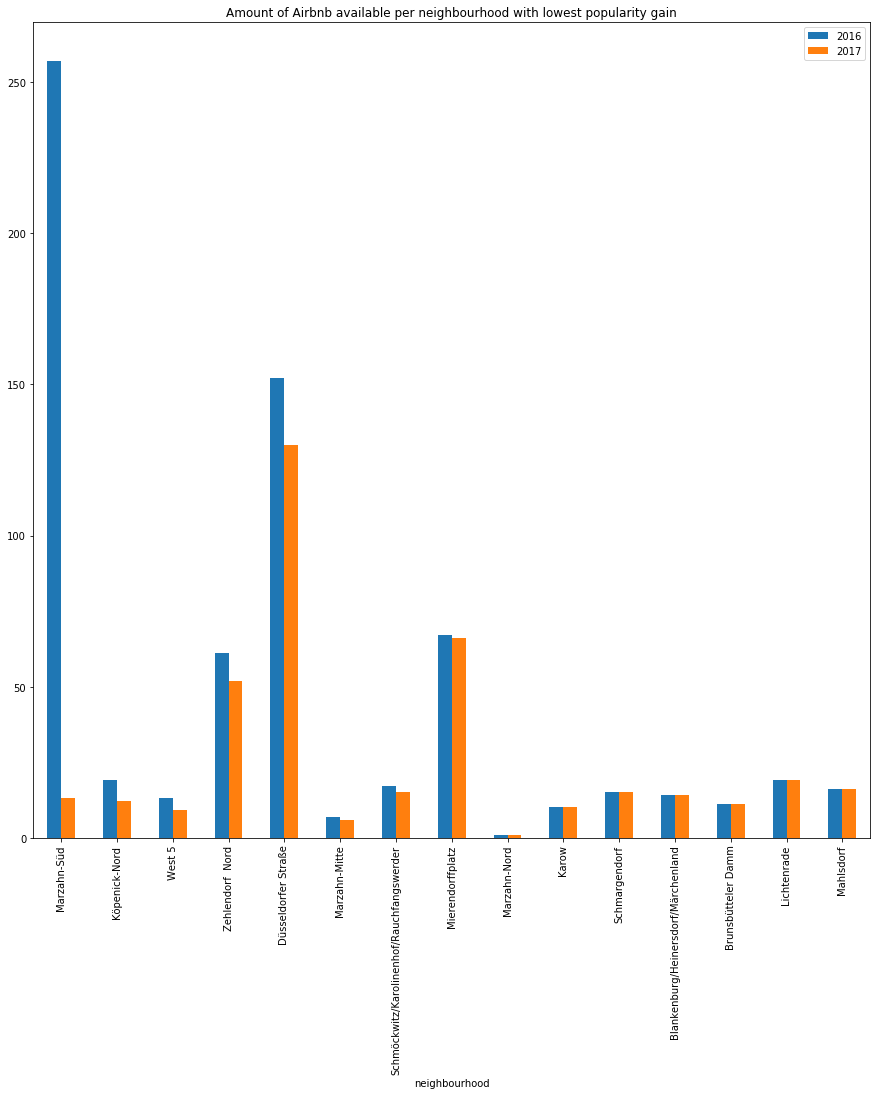

In [17]:
berlin_ng_stat_merge = berlin_ng_stat_merge.sort_values(by=['increase'], ascending=True)
berlin_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['2016', '2017'], kind='bar', figsize=(15, 15), title="Amount of Airbnb available per neighbourhood with lowest popularity gain")

In [18]:
tmp = berlin_ng_stat_merge
tmp = tmp.iloc[:15, :].reset_index()
tmp['counts'] = tmp['increase']
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), tmp)

###  Amsterdam - Inside Airbnb

Here we display the density of usage of Airbnb across the different neighbourhood of the city.

In [19]:
amsterdam_listing_ng_names = amsterdam_listing_2015.neighbourhood.unique()
amsterdam_listing_2015_neig_stats = amsterdam_listing_2015.groupby("neighbourhood").size().reset_index(name="counts")

The next plot shows the number of available AirBnB per number of night in Amsterdam.
This first thing we can notice on this graph is that the number of AirBnB increased a lot between 2015 and 2017, we can also observe that many AirBnb are only available for less than 100 days, compared to 2015 where most were available more than 250 days.

This can be explained by the regulation of AirBnb in Amsterdam that took place in 2017 where most of the AirBnB rentals were limited to at most 60 days.

Why are there still so many above 60 days ? This could be explain through the fact that those data only tells us when the place was available, not if it was rented during the whole time it is available.

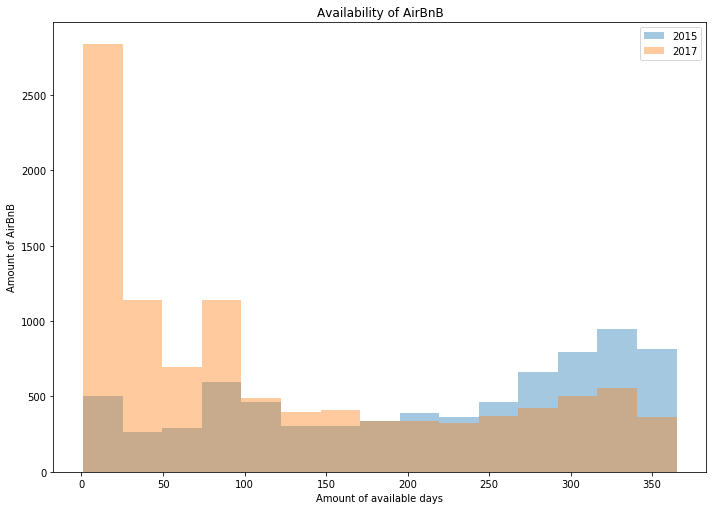

In [20]:
bins = 15

def plot_availability_hist(calendar):
    count = calendar.groupby('listing_id')['available'].apply(lambda x: (x=='t').sum()).reset_index(name='count')
    count = count[count['count'] != 0]
    return count['count']

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.distplot(plot_availability_hist(amsterdam_calendar_data_2015), ax=ax, kde=False, label='2015', bins=bins)
sns.distplot(plot_availability_hist(amsterdam_calendar_data_2017), ax=ax, kde=False, label='2017', bins=bins)

plt.title('Availability of AirBnB')

ax.set(xlabel='Amount of available days', ylabel='Amount of AirBnB')

plt.legend()
plt.show()

In [21]:
neighbourhood_map(folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
    ), os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson"), amsterdam_listing_2015_neig_stats)

We explore a bit of temporal data to see how the service is used during one full year. We look at what has changed
between 2015 and 2017.

In [22]:
am_mean_price_15 = amsterdam_calendar_data_2015.groupby("date").mean().reset_index("date")
am_mean_price_17 = amsterdam_calendar_data_2017.groupby("date").mean().reset_index("date")

am_mean_price_15['date_wo_year'] = am_mean_price_15["date"].apply(lambda x: str(x[5:]))
am_mean_price_17['date_wo_year'] = am_mean_price_17["date"].apply(lambda x: str(x[5:]))


am_std_price_15 = amsterdam_calendar_data_2015.groupby("date").std().reset_index("date")
am_std_price_17 = amsterdam_calendar_data_2017.groupby("date").std().reset_index("date")

days = am_mean_price_15["date"].unique()

Now than we have the date without year column, we can merge the two dataframes using it and have the mean price per day in 2015 and 2017

In [23]:
joined_date = pd.merge(am_mean_price_15, am_mean_price_17, on="date_wo_year").sort_values(by="date_wo_year")

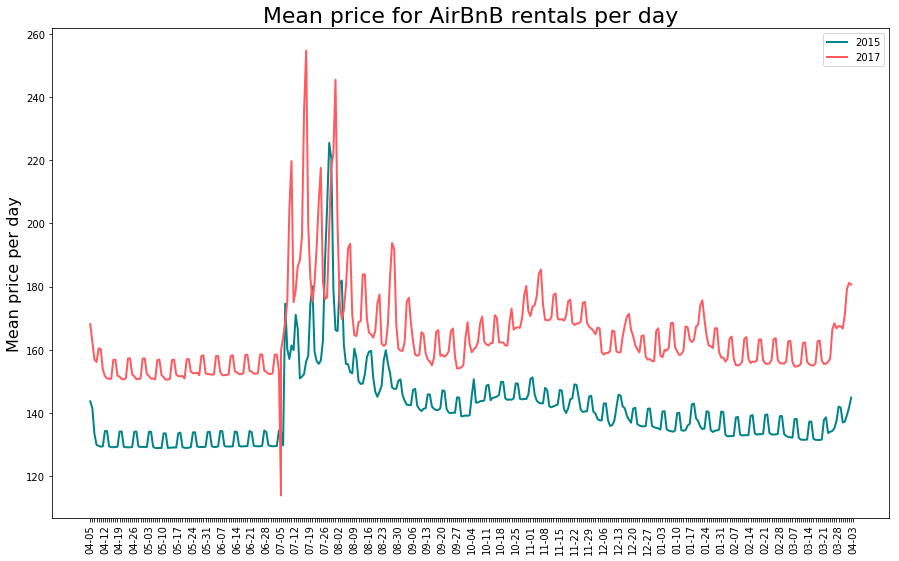

In [24]:
def plot_mean_prices(dataframe):
    plt.figure(figsize=(15, 9))

    plt.ylabel("Mean price per day", fontsize=16)  

    labels = []
    for i in range(len(dataframe['date_wo_year'])):
        if i%7 == 0:
            labels.append(dataframe['date_wo_year'][i])
        else:
            labels.append("")

    plt.plot(dataframe['date_wo_year'], dataframe["price_x"], color="#008489", lw=2, label="2015")
    plt.plot(dataframe['date_wo_year'], dataframe["price_y"], color="#ff5a5f", lw=2, label="2017")
    plt.legend(loc='upper right')
    plt.xticks(range(len(labels)), labels, rotation = 90)

    plt.title("Mean price for AirBnB rentals per day", fontsize=22)
    plt.show()

plot_mean_prices(joined_date)

From those two graphs we can see a pattern, there are more or less 52 spikes corresponding to the number of weekends in the year. We can also see that April/May seems to be more attractive for people to travel, explaining the high prices during those months.

_TODO: Explain/Exploit results

In [25]:
ams_listing_2017_neig_stats = amsterdam_listing_2017.groupby("neighbourhood").size().reset_index(name="counts")
ams_listing_2015_neig_stats = amsterdam_listing_2015.groupby("neighbourhood").size().reset_index(name="counts")
ams_ng_stat_merge = ams_listing_2015_neig_stats.merge(ams_listing_2017_neig_stats, on='neighbourhood')
ams_ng_stat_merge['diff'] = ams_ng_stat_merge['counts_y'] - ams_ng_stat_merge['counts_x']
ams_ng_stat_merge['increase'] = ams_ng_stat_merge['counts_y'] / ams_ng_stat_merge['counts_x']
ams_ng_stat_merge['2015'] = ams_ng_stat_merge['counts_x']
ams_ng_stat_merge['2017'] = ams_ng_stat_merge['counts_y']

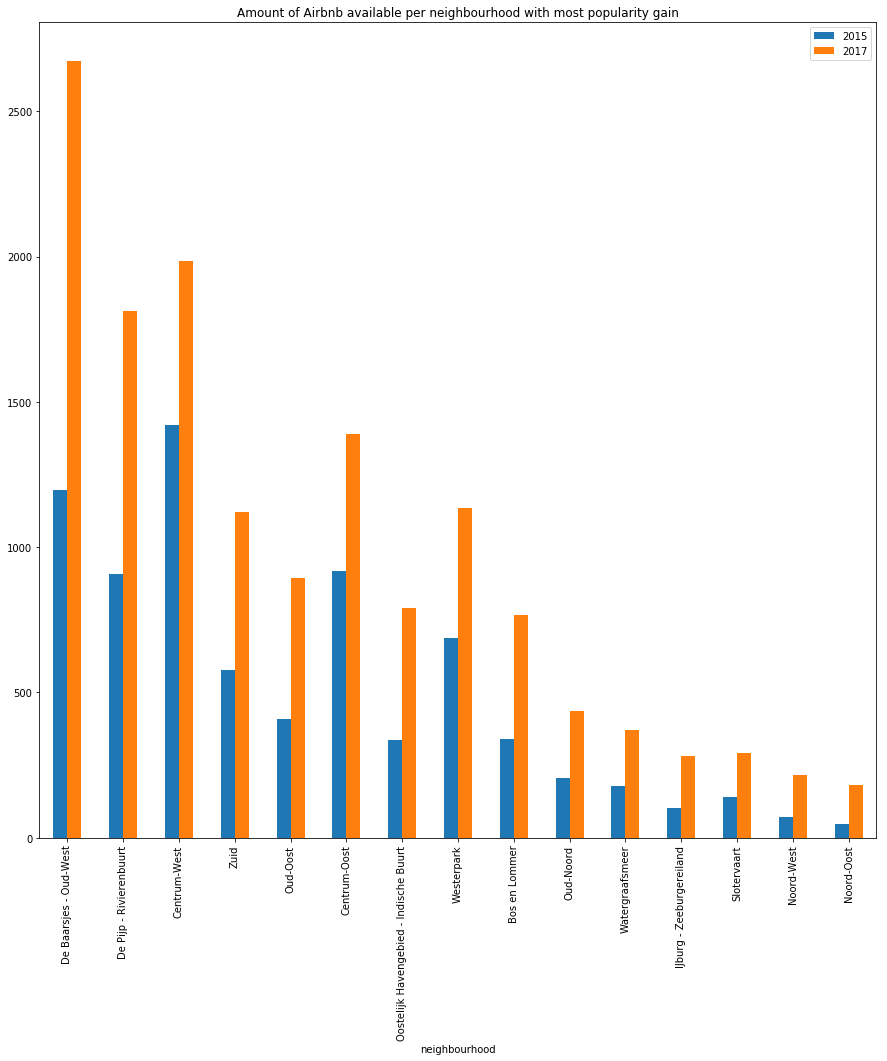

In [26]:
ams_ng_stat_merge = ams_ng_stat_merge.sort_values(by=['diff'], ascending=False)
ams_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['2015', '2017'], kind='bar', figsize=(15, 15), title="Amount of Airbnb available per neighbourhood with most popularity gain")

In [27]:
len(ams_ng_stat_merge[ams_ng_stat_merge['diff'] < 0])

0

In the case of Amsterdam, all neighbourhoods gained in popularity (represented by the number of AirBnB available). 
Why this difference with Berlin ? Our guess is that Berlin is much more wide city than Amsterdam, and people using AirBnB seems to care beeing in the center, which makes no big difference in AirBnB but a lot in Berlin.

In [28]:
tmp = ams_ng_stat_merge
tmp = tmp.iloc[:5, :].reset_index()
tmp['counts'] = tmp['increase']

neighbourhood_map(folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
), os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson"), tmp)


## National data imports

Those data come from official ressources regarding the two cities.

For Berlin: https://daten.berlin.de/

For Amsterdam: https://data.overheid.nl/

In [29]:
def load_national_data(city, file_name):
    file = os.path.join(DATASETS_ROOT, city, NATIONAL, file_name)
    return pd.read_csv(file)

In [30]:
am_2013_to_2017_number_of_housing = load_national_data("Amsterdam", "2013_to_2017_number_of_housing.csv")
am_2015_2016_total_sales_prices = load_national_data("Amsterdam", "2015_2016_total_sales_prices.csv")
am_2017_number_of_room_per_dwelling = load_national_data("Amsterdam", "2017_number_of_room_per_dwelling.csv")
am_2017_satisfaction_with_living_environment = load_national_data("Amsterdam", "2017_satisfaction_with_living_environment.csv")

am_2013_to_2017_number_of_housing['neighbourhood'] = am_2013_to_2017_number_of_housing['district']
am_2013_to_2017_number_of_housing = am_2013_to_2017_number_of_housing.sort_values('district')

In [31]:
be_2016_tourists_income = load_national_data("Berlin", "2016_tourists_income.csv")
be_2017_rental_price = load_national_data("Berlin", "2017_rental_price.csv")
be_overnight = load_national_data("Berlin", "2012_to_2016_overnight_stays.csv")

am_2013_to_2017_number_of_housing

district   2013   2014   2015   2016   2017  neighbourhood
0     A  Centrum  53645  53794  53932  54217  54026     A  Centrum
1   B  Westpoort     55     51     48     47     38   B  Westpoort
2        E  West  76324  76502  77003  78211  78465        E  West
3  F  Nieuw-West  62487  62800  63846  64561  64838  F  Nieuw-West
4        K  Zuid  77586  77725  78238  79395  80036        K  Zuid
5        M  Oost  61560  62984  63834  65648  67430        M  Oost
6       N  Noord  40898  41212  41557  41878  42360       N  Noord
7    T  Zuidoost  38349  38422  38638  39828  40665    T  Zuidoost

## Exploring data from national sources

### Berlin - National Data

Analysis of the price of housing over time.

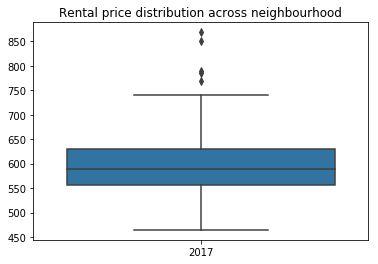

In [32]:
be_rental = be_2017_rental_price * 60 # because the data is in price per square meter for 60 square meters apartments

g = sns.boxplot(data=be_rental)
g.set_xticklabels(['2017'])
g.set_title('Rental price distribution across neighbourhood')
plt.show(g)

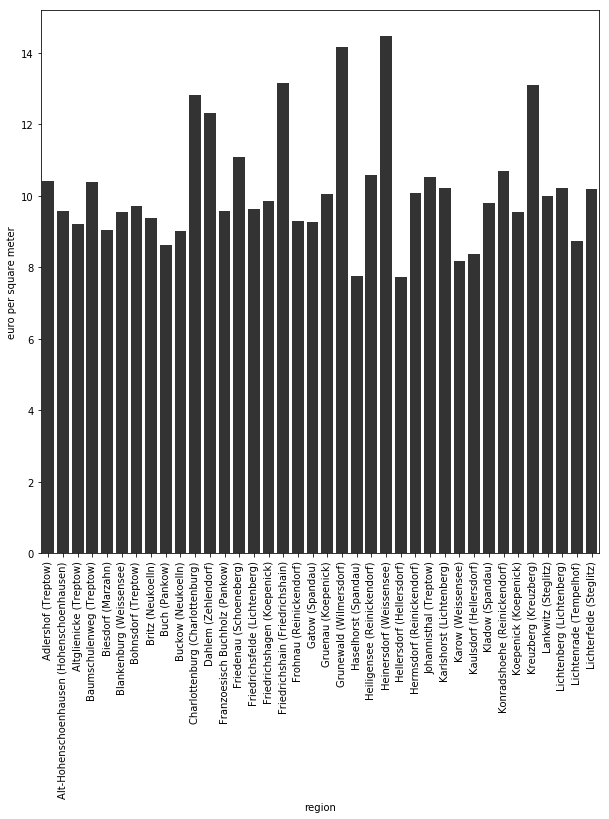

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
g = sns.barplot(data=be_2017_rental_price, x='region', y='euro per square meter', ax=ax, color="#333333FF")
g.set
g.set_xticklabels(be_2017_rental_price['region'], rotation=90)
plt.show(g)

_TODO: We will be able to use those prices per neighbourhood in comparison with Inside Airbnb data._

Size of apartments in different neighbourhoods.


In [34]:
berlin_listing_2016_full['square_feet'].mean()

434.76061320754718

Rental price categories for private housing.


Satisfaction with house and living environment per district.


### Amsterdam - National Data

Analysis of the price of housing over time.

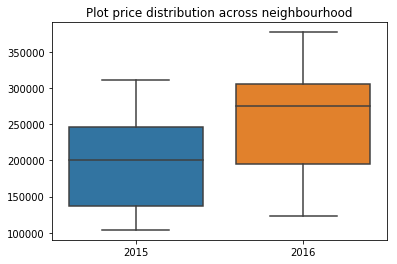

In [35]:
am_sales_prices = am_2015_2016_total_sales_prices[['district', 'average price of plots mil 2015', 'average price of plots mil 2016']]
am_sales_prices = am_sales_prices * 1000 # because data are stored divided by a thousand

g = sns.boxplot(data=am_sales_prices)
g.set_xticklabels(['2015', '2016'])
g.set_title('Plot price distribution across neighbourhood')
plt.show(g)

From this we see that the prices increase over time. We will later compare this per neighbourhood and compare it to the data from Inside Airbnb.

Size of apartments in different neighbourhoods.

Rental price categories for private housing.


Satisfaction with house and living environment per district.


## Combining and comparing the results

Finding correlation between national and Inside Airbnb data

### Mapping Neighbourhoods across data

In the data from AirBnb, neighourhoods are splitted into much more smaller pieces than on the data from official websites (for both Berlin and Amsterdam), in order to compare them we had to create a mapping between those neighbourhoods, this is located inside the `berlin_map_neighbourhoods.csv` and `asmterdam_map_neighbourhoods.csv`

#### Amsterdam


In [36]:
# Load CSV
# Join with the Inside AirBnb dataframe
# Join the result with the official city dataframe
def load_mapping_city_neighbourhoods(city):
    am_neigh_mapping_file = os.path.join(DATASETS_ROOT, city, "neighbourhood_map.csv")
    tmp = pd.read_csv(am_neigh_mapping_file)
    tmp['neighbourhood'] = tmp['airbnb_name']
    return tmp


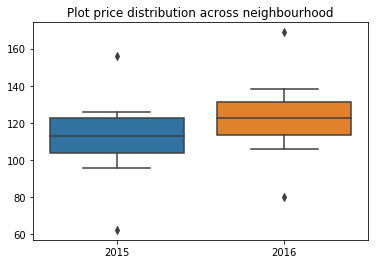

In [37]:
amsterdam_mapping = load_mapping_city_neighbourhoods("Amsterdam")
amsterdam_mapped_2017 = amsterdam_listing_2017.merge(amsterdam_mapping, on='neighbourhood')
amsterdam_mapped_2015 = amsterdam_listing_2015.merge(amsterdam_mapping, on='neighbourhood')


tmp = amsterdam_mapped_2015.groupby('official_name')[['price']].mean()
tmp['price_2016'] = amsterdam_mapped_2017.groupby('official_name')[['price']].mean()

g = sns.boxplot(data=tmp)

g.set_title('Plot price distribution across neighbourhood')
g.set_xticklabels(['2015', '2016'])
plt.show(g)

In the following graph we drew a heatmap of the correlation between the number of available Airbnb per neighbourhood and some happiness criterium in each of them. As we can observe, the correlation between this number and the `grade` of the neighbourhood is weak, this seems to show thhat people using Airbnb do not really care a about the neigbourhood.

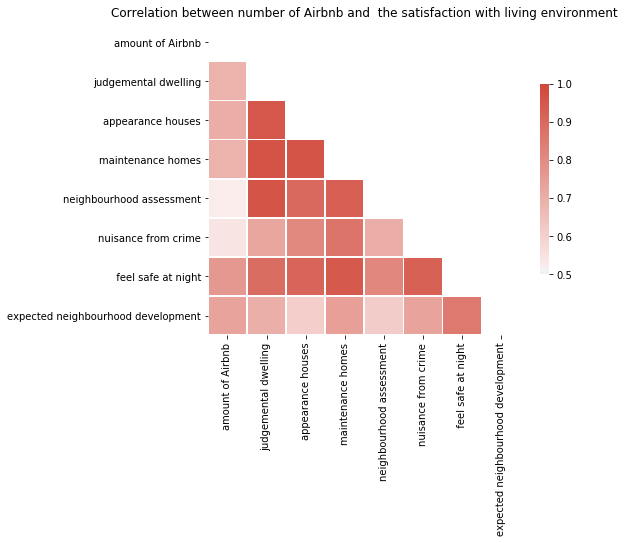

In [38]:
am_2017_satisfaction_with_living_environment['neighbourhood'] = am_2017_satisfaction_with_living_environment['distrrict']


t = amsterdam_mapped_2015.groupby('official_name').size().reset_index(name='counts')
t.columns = ['neighbourhood', 'amount of Airbnb']

t = t.merge(am_2017_satisfaction_with_living_environment, on='neighbourhood').sort_values('amount of Airbnb', ascending=False) #.iloc[:, :4]
del t['distrrict']
del t['total judgment']

corr = t.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 7))

cmap = sns.diverging_palette(220, 15, as_cmap=True, n=2)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.5, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation between number of Airbnb and  the satisfaction with living environment")
plt.show()

In [46]:
count_am_2015 = amsterdam_mapped_2015.groupby('official_name').size().reset_index(name='counts')
count_am_2017 = amsterdam_mapped_2017.groupby('official_name').size().reset_index(name='counts')

count_am_2015.columns = ['neighbourhood', 'amount of Airbnb 2015']
count_am_2017.columns = ['neighbourhood', 'amount of Airbnb 2017']

count_am_2015 = count_am_2015.sort_values('neighbourhood')
count_am_2017 = count_am_2017.sort_values('neighbourhood')

wo_wesport = am_2013_to_2017_number_of_housing[~am_2013_to_2017_number_of_housing['neighbourhood'].str.contains("Westpoort")].reset_index()
count_am_2015 = count_am_2015.join(wo_wesport, rsuffix='_right')[['neighbourhood', '2015', '2017', 'amount of Airbnb 2015']]
count_am = count_am_2015.merge(count_am_2017, on='neighbourhood')

count_am['wo_airbnb_2015'] = count_am['2015'] - count_am['amount of Airbnb 2015']
count_am['wo_airbnb_2017'] = count_am['2017'] - count_am['amount of Airbnb 2017']

tmp = count_am[['amount of Airbnb 2015', 'wo_airbnb_2015', 'amount of Airbnb 2017', 'wo_airbnb_2017']].sum()
count_am = count_am.append({'neighbourhood': 'Amsterdam', 'amount of Airbnb 2015': tmp['amount of Airbnb 2015'], 'wo_airbnb_2015' : tmp['wo_airbnb_2015'],
                           'amount of Airbnb 2017': tmp['amount of Airbnb 2017'], 'wo_airbnb_2017' : tmp['wo_airbnb_2017']}, ignore_index=True)

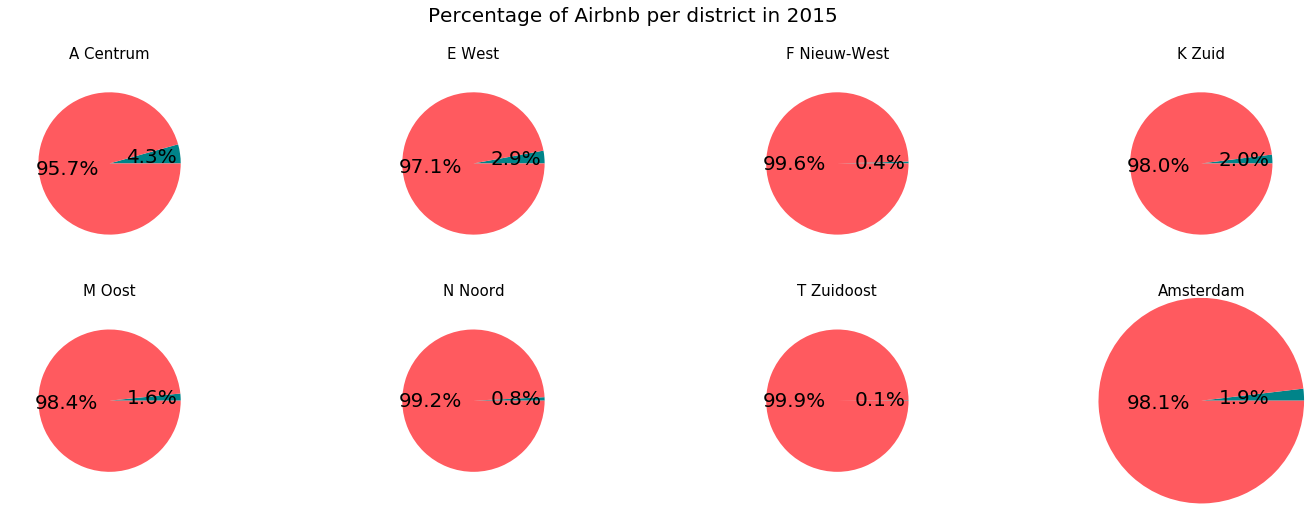

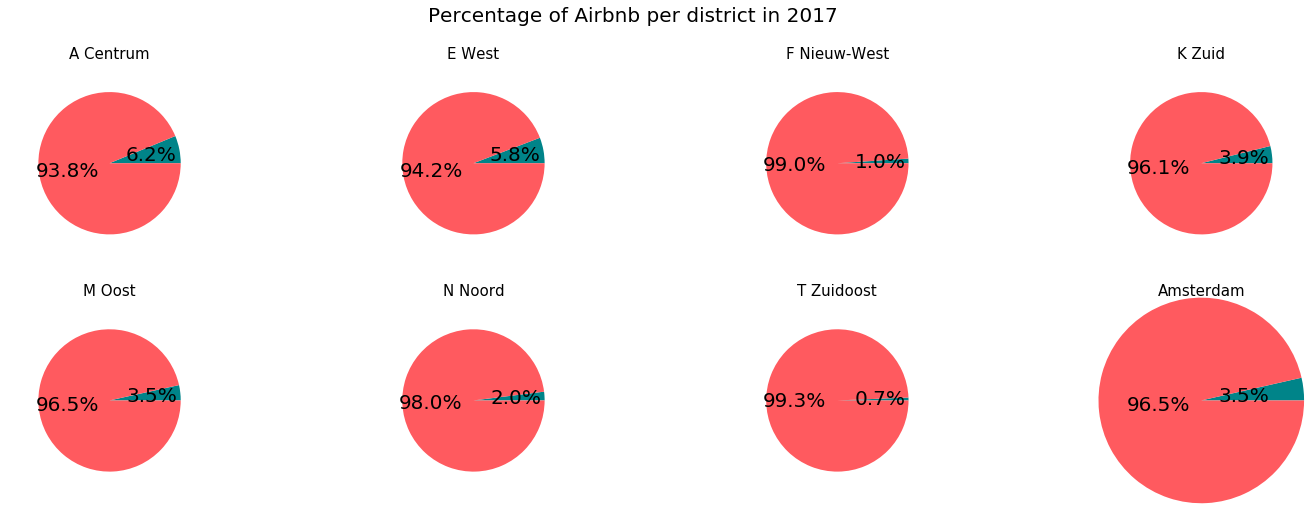

In [47]:
def plot_chart_by_year(df, year):
    plt.figure(1, figsize=(25, 8))
    plt.suptitle('Percentage of Airbnb per district in ' + year, fontsize=20)

    p = None
    for i in range(len(df)):
        plt.subplot(2, 4, i+1, aspect=1)
        p, txts, autotexts = plt.pie(df[['amount of Airbnb ' + year, 'wo_airbnb_' + year]].T[i], colors=["#008489", "#ff5a5f"], radius=0.9, autopct='%1.1f%%')
        autotexts[0].set_fontsize(20)
        autotexts[1].set_fontsize(20)

        plt.title(df['neighbourhood'][i], fontsize=15)

    p[0].set_radius(1.3)
    p[1].set_radius(1.3)
    plt.show()

plot_chart_by_year(count_am, "2015")
plot_chart_by_year(count_am, "2017")


#### Berlin

In [ ]:
berlin_mapping = load_mapping_city_neighbourhoods("Berlin")
berlin_listing_2017.merge(berlin_mapping, on='neighbourhood')
berlin_mapping
amsterdam_mapping

## Conclusion

One interesting challenge with this project was to gather data from website in other languages. German was still okay for us - even if the vocabulary was quite technical sometimes. Gathering data from a dutch website was more challenging, but automatic translation tools helped us.

In this work, we learned that […]